In [52]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from scipy.io import loadmat
from skimage import color

In [53]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.decomposition import PCA

In [54]:
def load_images(hsv = False, directory = "images/"):
    file_list = os.listdir(directory)
    file_num = len(file_list)
    images = []
    print("Loading ", file_num, " images...")
    for file_name in file_list:
        image = Image.open(directory+file_name)
        if hsv:
            images.append(color.rgb2hsv(image))
        else:
            images.append(np.array(image))
            
    print("Finished!")
    return np.array(images)


In [55]:
def load_landmarks(directory = "landmarks/"):
    file_list = os.listdir(directory)
    file_num = len(file_list)
    landmarks = []
    print("Loading ", file_num, "landmarks...")
    for file_name in file_list:
        landmarks.append(loadmat(directory+file_name)['lms'])
    print("Finished!")
    return np.array(landmarks)

# (1) Perform FDA Directly to RGB Images and Landmarks

In [56]:
male_images = load_images(hsv=False, directory="male_images/")
male_landmarks = load_landmarks(directory="male_landmarks/")
female_images = load_images(hsv=False, directory="female_images/")
female_landmarks = load_landmarks(directory="female_landmarks/")

Loading  412  images...
Finished!
Loading  412 landmarks...
Finished!
Loading  588  images...
Finished!
Loading  588 landmarks...
Finished!


In [57]:
labels = np.array([0 for i in range(len(male_images))] + [1 for i in range(len(female_images))])

In [58]:
male_and_female_images = np.concatenate([male_images, female_images], axis = 0)
male_and_female_landmarks = np.concatenate([male_landmarks, female_landmarks], axis = 0)

male_and_female_images_flatten = male_and_female_images.reshape(1000, -1)
male_and_female_landmarks_flatten = male_and_female_landmarks.reshape(1000, -1)

images_and_landmarks_combined = np.concatenate([male_and_female_images_flatten, male_and_female_landmarks_flatten], axis = 1)

In [59]:
images_and_landmarks_combined.shape

(1000, 49288)

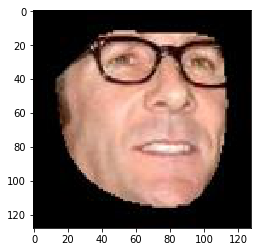

male


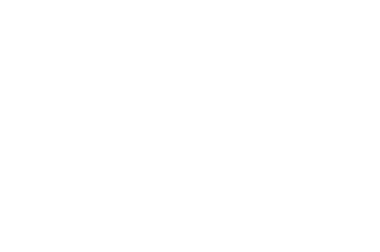

In [60]:
#plot a random image
random_idx = np.random.randint(len(male_and_female_images))
plt.imshow(male_and_female_images[random_idx])
plt.show()
plt.axis("off")
print("male" if labels[random_idx] == 0 else "female")

In [61]:
##training and testing data split

# randomly shuffle 
images_and_landmarks_combined, labels = shuffle(images_and_landmarks_combined, labels)

train_data = images_and_landmarks_combined[:800]
test_data = images_and_landmarks_combined[800:]
train_labels = labels[:800]
test_labels = labels[800:]


#How many male/female faces in training/testing data
print("Males : Females in Training Data: ", np.sum(train_labels == 0),":",np.sum(train_labels == 1))
print("Males : Females in Testing Data: ", np.sum(test_labels == 0),":",np.sum(test_labels == 1))


Males : Females in Training Data:  336 : 464
Males : Females in Testing Data:  76 : 124


In [63]:
#standardize training data
scaler = StandardScaler(with_mean=True, with_std=True)
scaler.fit(train_data)

train_data_scaled = scaler.transform(train_data)
test_data_scaled = scaler.transform(test_data)


In [64]:
###Perform the Fisher Linear Discriminant Analysis
lda = LinearDiscriminantAnalysis()
lda.fit(train_data_scaled, train_labels)


C:\Users\shadi\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [65]:
#get training and testing scores
#training part
print("Training accuracy: ", lda.score(train_data_scaled, train_labels))

male_idxes = train_labels == 0
print("Training accuracy on male faces: ", lda.score(train_data_scaled[male_idxes], train_labels[male_idxes]))

female_idxes = train_labels == 1
print("Training accuracy on male faces: ", lda.score(train_data_scaled[female_idxes], train_labels[female_idxes]))

#testing part
print("Testing accuracy: ", lda.score(test_data_scaled, test_labels))

male_idxes = test_labels ==0
print("Test accuracy on male faces: ", lda.score(test_data_scaled[male_idxes], test_labels[male_idxes]))

female_idxes = test_labels == 1
print("Test accuracy on male faces: ", lda.score(test_data_scaled[female_idxes], test_labels[female_idxes]))

Training accuracy:  0.965
Training accuracy on male faces:  0.9642857142857143
Training accuracy on male faces:  0.9655172413793104
Testing accuracy:  0.805
Test accuracy on male faces:  0.8421052631578947
Test accuracy on male faces:  0.782258064516129


# (2) Perform FDA Based on 2.2 and 2.3

In [66]:
def get_warped_images(images, landmarks, to_landmarks):
    warped_images = np.zeros(images.shape)
    H = warped_images.shape[0]
    for i in range(H):
        if i % int(H / 5) == 0:
            print("Running at...", i,"/", H)
        warped_images[i] = warp(images[i], landmarks[i], to_landmarks[i])
        
    print("Finished")
    return warped_images

In [67]:
#split training and testing data
labels = np.array([0 for i in range(len(male_images))] + [1 for i in range(len(female_images))])
images_shuffled, landmarks_shuffled, labels_shuffled = shuffle(male_and_female_images, male_and_female_landmarks, labels)


train_images = images_shuffled[:800]
test_images = images_shuffled[800:]

train_landmarks = landmarks_shuffled[:800]
test_landmarks = landmarks_shuffled[800:]

train_labels = labels_shuffled[:800]
test_labels = labels_shuffled[800:]


In [68]:
#Get the mean
train_landmarks_flatten = train_landmarks.reshape(800, -1)

scaler_landmark = StandardScaler(with_std=False)
train_landmarks_flatten_scaled = scaler_landmark.fit_transform(train_landmarks_flatten)


mean_landmarks = scaler_landmark.mean_.reshape(68,2)

In [69]:
# -*- coding: utf-8 -*-
"""
Created on Fri Sep 14 15:26:24 2018

@author: dell
"""
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sys
import datetime
import imageio

##################################
# Apply affine transform calculated using srcTri and dstTri to src and
# output an image of size.
def applyAffineTransform(src, srcTri, dstTri, size) :
    
    # Given a pair of triangles, find the affine transform.
    warpMat = cv2.getAffineTransform( np.float32(srcTri), np.float32(dstTri) )
    
    # Apply the Affine Transform just found to the src image
    dst = cv2.warpAffine( src, warpMat, (size[0], size[1]), None, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101 )

    return dst


# Check if a point is inside a rectangle
def rectContains(rect, point) :
    if point[0] < rect[0] :
        return False
    elif point[1] < rect[1] :
        return False
    elif point[0] > rect[0] + rect[2] :
        return False
    elif point[1] > rect[1] + rect[3] :
        return False
    return True

#calculate delanauy triangle
def calculateDelaunayTriangles(rect, points):
    #create subdiv
    subdiv = cv2.Subdiv2D(rect);
    
    # Insert points into subdiv
    for p in points:
        p1=(int(p[0]),int(p[1]))
        if p1[1]<=rect[2]-1 and p1[0]<=rect[2]-1 and p1[1]>=rect[0] and p1[0]>=rect[0]:
            subdiv.insert(p1) 
    
    triangleList = subdiv.getTriangleList();
    
    delaunayTri = []
    
    pt = []    
        
    for t in triangleList:        
        pt.append((t[0], t[1]))
        pt.append((t[2], t[3]))
        pt.append((t[4], t[5]))
        
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])        
        
        if rectContains(rect, pt1) and rectContains(rect, pt2) and rectContains(rect, pt3):
            ind = []
            #Get face-points (from 68 face detector) by coordinates
            for j in range(0, 3):
                for k in range(0, len(points)):                    
                    if(abs(pt[j][0] - points[k][0]) < 1.0 and abs(pt[j][1] - points[k][1]) < 1.0):
                        ind.append(k)    
            # Three points form a triangle. Triangle array corresponds to the file tri.txt in FaceMorph 
            if len(ind) == 3:                                                
                delaunayTri.append((ind[0], ind[1], ind[2]))
        
        pt = []        
            
    
    return delaunayTri

# Warps and alpha blends triangular regions from img1 and img2 to img
def warpTriangle(img1, img2, t1, t2) :

    # Find bounding rectangle for each triangle
    r1 = cv2.boundingRect(np.float32([t1]))
    r2 = cv2.boundingRect(np.float32([t2]))

    # Offset points by left top corner of the respective rectangles
    t1Rect = [] 
    t2Rect = []
    t2RectInt = []

    for i in range(0, 3):
        t1Rect.append(((t1[i][0] - r1[0]),(t1[i][1] - r1[1])))
        t2Rect.append(((t2[i][0] - r2[0]),(t2[i][1] - r2[1])))
        t2RectInt.append(((t2[i][0] - r2[0]),(t2[i][1] - r2[1])))

    w,h,num_chans = img1.shape
    # Get mask by filling triangle
    mask = np.zeros((r2[3], r2[2], num_chans), dtype = np.float32)
    cv2.fillConvexPoly(mask, np.int32(t2RectInt), (1.0, 1.0, 1.0), 16, 0);

    # Apply warpImage to small rectangular patches
    img1Rect = img1[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]
    #img2Rect = np.zeros((r2[3], r2[2]), dtype = img1Rect.dtype)
    
    size = (r2[2], r2[3])

    img2Rect = applyAffineTransform(img1Rect, t1Rect, t2Rect, size)
    if num_chans==1:
        img2Rect=np.reshape(img2Rect,(r2[3], r2[2], num_chans))
    
    img2Rect = img2Rect * mask

    # Copy triangular region of the rectangular patch to the output image
    if num_chans==1:
        img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] * ( 1.0 - mask )
     
    else:
        img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] * ( (1.0, 1.0, 1.0) - mask )
     
    img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] + img2Rect 

###################################
def warp(Image,sc,tc):
    '''
    Image: the image to be warped
    sc: original landmarks
    tc: warped landmarks
    '''
    HW,_,_=Image.shape
    cornerps=[[0,0],[0,HW-1],[HW-1,0],[HW-1,HW-1]]
    #cornerps=[[0,0],[0,HW-1],[HW-1,0],[HW-1,HW-1],[0,np.floor(HW/2)],[np.floor(HW/2),0],[HW-1,np.floor(HW/2)],[np.floor(HW/2),HW-1]]

    scl=sc.astype(np.int64).tolist()+cornerps
    tcl=tc.astype(np.int64).tolist()+cornerps
    imgWarped = np.copy(Image);    
    rect = (0, 0, HW, HW)
    dt = calculateDelaunayTriangles(rect,tcl)
# Apply affine transformation to Delaunay triangles
    for i in range(0, len(dt)):
        t1 = []
        t2 = []
        
        #get points for img1, img2 corresponding to the triangles
        for j in range(0, 3):
            t1.append(scl[dt[i][j]])
            t2.append(tcl[dt[i][j]])
        
        warpTriangle(Image, imgWarped, t1, t2)
    return imgWarped

#########################################
def plot(samples,Nh,Nc,channel,IMG_HEIGHT, IMG_WIDTH):
    fig = plt.figure(figsize=(Nc, Nh))
    plt.clf()
    gs = gridspec.GridSpec(Nh, Nc)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples[0:Nh*Nc,:,:,:]):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        if channel==1:
            image=sample.reshape(IMG_HEIGHT, IMG_WIDTH)
            immin=(image[:,:]).min()
            immax=(image[:,:]).max()
            image=(image-immin)/(immax-immin+1e-8)
            plt.imshow(image,cmap ='gray')
        else:
            image=sample.reshape(IMG_HEIGHT, IMG_WIDTH,channel)
            immin=(image[:,:,:]).min()
            immax=(image[:,:,:]).max()
            image=(image-immin)/(immax-immin+1e-8)
            plt.imshow(image)
    return fig 






In [70]:
train_images_warped = get_warped_images(train_images, train_landmarks, [mean_landmarks]*800)

Running at... 0 / 800
Running at... 160 / 800
Running at... 320 / 800
Running at... 480 / 800
Running at... 640 / 800
Finished


In [71]:
train_images_warped = train_images_warped / 255.0

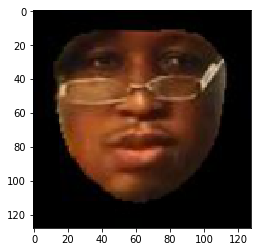

male


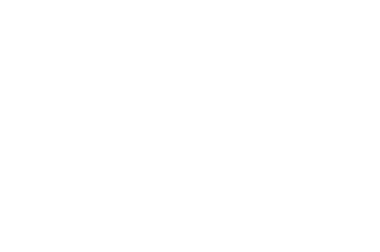

In [72]:
#plot a random image
random_idx = np.random.randint(len(train_images_warped))
plt.imshow(train_images_warped[random_idx])
plt.show()
plt.axis("off")
print("male" if train_labels[random_idx] == 0 else "female")

In [73]:
train_images_warped_hsv = np.array([color.rgb2hsv(train_images_warped[i]) for i in range(len(train_images_warped))])

In [74]:
train_images_warped_hsv_value = train_images_warped_hsv[:,:,:,2]
train_images_warped_hsv_value_flatten = train_images_warped_hsv_value.reshape(800, -1)

In [75]:
#standardize image value-channel
scaler_value = StandardScaler(with_std=False)
train_images_warped_hsv_value_flatten_scaled = scaler.fit_transform(train_images_warped_hsv_value_flatten)

In [76]:
#pca
pca_images = PCA(n_components=50)
pca_images.fit(train_images_warped_hsv_value_flatten_scaled)

train_images_pca_scores = pca_images.transform(train_images_warped_hsv_value_flatten_scaled)

pca_landmarks = PCA(n_components=10)
pca_landmarks.fit(train_landmarks_flatten_scaled)

train_landmarks_pca_scores = pca_landmarks.transform(train_landmarks_flatten_scaled)

In [77]:
#lda
train_pca_scores = np.concatenate([train_images_pca_scores, train_landmarks_pca_scores], axis = 1)

#scaler for lda
scaler_lda = StandardScaler(with_mean=False, with_std=False)
train_pca_scores_scaled = scaler_lda.fit_transform(train_pca_scores)

In [78]:
#FINALLY, LDA
lda_pca = LinearDiscriminantAnalysis()
lda_pca.fit(train_pca_scores_scaled, train_labels)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [79]:
#get training and testing scores
#training part
print("Training accuracy: ", lda_pca.score(train_pca_scores_scaled, train_labels))

male_idxes = train_labels == 0
print("Training accuracy on male faces: ", lda_pca.score(train_pca_scores_scaled[male_idxes], train_labels[male_idxes]))

female_idxes = train_labels == 1
print("Training accuracy on female faces: ", lda_pca.score(train_pca_scores_scaled[female_idxes], train_labels[female_idxes]))

Training accuracy:  0.96
Training accuracy on male faces:  0.9541284403669725
Training accuracy on female faces:  0.9640591966173362


In [80]:
#Processing Testing Data
test_images_warped = get_warped_images(test_images, test_landmarks, [mean_landmarks]*800)

Running at... 0 / 200
Running at... 40 / 200
Running at... 80 / 200
Running at... 120 / 200
Running at... 160 / 200
Finished


In [81]:
test_images_warped = test_images_warped / 255.0
test_images_warped_hsv = np.array([color.rgb2hsv(test_images_warped[i]) for i in range(len(test_images_warped))])
test_images_warped_hsv_value = test_images_warped_hsv[:,:,:,2]
test_images_warped_hsv_value_flatten = test_images_warped_hsv_value.reshape(200, -1)
test_images_warped_hsv_value_flatten_scaled = scaler.fit_transform(test_images_warped_hsv_value_flatten)

In [82]:
test_images_warped_hsv_value_flatten_scaled.shape

(200, 16384)

In [83]:
test_images_pca_scores = pca_images.transform(test_images_warped_hsv_value_flatten_scaled)

test_landmarks_flatten = test_landmarks.reshape(200, -1)
test_landmarks_flatten_scaled = scaler_landmark.transform(test_landmarks_flatten)
test_landmarks_pca_scores = pca_landmarks.transform(test_landmarks_flatten_scaled)

test_pca_scores = np.concatenate([test_images_pca_scores, test_landmarks_pca_scores], axis = 1)

test_pca_scores_scaled = scaler_lda.transform(test_pca_scores)

In [84]:
#get training and testing scores
#testing part
print("Testing accuracy: ", lda_pca.score(test_pca_scores_scaled, test_labels))

male_idxes = test_labels == 0
print("Testing accuracy on male faces: ", lda_pca.score(test_pca_scores_scaled[male_idxes], test_labels[male_idxes]))

female_idxes = test_labels == 1
print("Testing accuracy on female faces: ", lda_pca.score(test_pca_scores_scaled[female_idxes], test_labels[female_idxes]))

Testing accuracy:  0.935
Testing accuracy on male faces:  0.9058823529411765
Testing accuracy on female faces:  0.9565217391304348


# *LDA for dimensional reduction

In [85]:
from sklearn.decomposition import PCA

In [86]:
pca = PCA(n_components=2)
pca_scores = pca.fit(train_pca_scores).transform(train_pca_scores)


In [87]:
colors = ['darkorange', 'turquoise']
lw = 0.05
target_names = ["male", "female"]

Text(0.5,1,'Scores for male/female faces(first two components)')

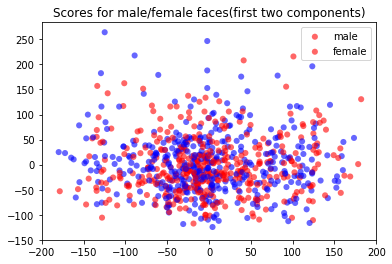

In [88]:
for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(pca_scores[train_labels == i, 0], pca_scores[train_labels == i, 1], color=['r','b'], alpha=.6, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('Scores for male/female faces(first two components)')

In [90]:
plt.show()

In [ ]:
'''
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
lda_pca_2 = LinearDiscriminantAnalysis(n_components=1)
lda_pca_2.fit(train_pca_scores_scaled, train_labels)


#get training and testing scores
#training part
print("Training accuracy: ", lda_pca_2.score(train_pca_scores_scaled, train_labels))

male_idxes = train_labels == 0
print("Training accuracy on male faces: ", lda_pca_2.score(train_pca_scores_scaled[male_idxes], train_labels[male_idxes]))

female_idxes = train_labels == 1
print("Training accuracy on male faces: ", lda_pca_2.score(train_pca_scores_scaled[female_idxes], train_labels[female_idxes]))

#get training and testing scores
#training part
print("Testing accuracy: ", lda_pca_2.score(test_pca_scores_scaled, test_labels))

male_idxes = test_labels == 0
print("Testing accuracy on male faces: ", lda_pca_2.score(test_pca_scores_scaled[male_idxes], test_labels[male_idxes]))

female_idxes = test_labels == 1
print("Testing accuracy on male faces: ", lda_pca_2.score(test_pca_scores_scaled[female_idxes], test_labels[female_idxes]))
'''